In [159]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import torch
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from copy import deepcopy
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from scipy.ndimage import gaussian_filter
from os.path import join as oj
import sys
import acd
from tqdm import tqdm
import pickle as pkl
import torchvision
import models
import time
from functools import partial
sys.path.append('..')
sys.path.append('../..')
# plt.style.use('dark_background')
from visualize import *
import visualize as viz
from transforms_torch import bandpass_filter
from numpy.fft import *
from data import *
from style import *
data_path = './cosmo'
torch.manual_seed(42)
np.random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [160]:
from acd_wooseok.acd.scores import cd

# load dataset and model

In [161]:
# params
img_size = 256
class_num = 1

100%|██████████| 100/100 [00:08<00:00, 11.34it/s]


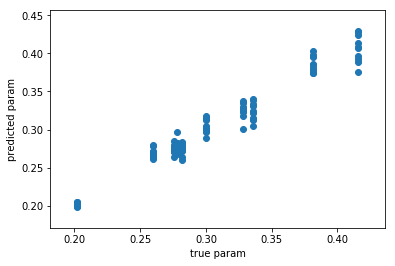

In [162]:
# cosmo dataset
transformer = transforms.Compose([ToTensor()])
mnu_dataset = MassMapsDataset(oj(data_path, 'cosmological_parameters.txt'),  
                              oj(data_path, 'z1_256'),
                              transform=transformer)

# dataloader
data_loader = torch.utils.data.DataLoader(mnu_dataset, batch_size=64, shuffle=False, num_workers=4)

# load model
model = models.load_model(model_name='resnet18', device=device, data_path=data_path).to(device)
model.eval()

# model prediction
with torch.no_grad():
    result = {'y': [], 'pred': []}
    for i in tqdm(range(100)):
        sample = mnu_dataset[i]
        x = sample['image']
        result['y'].append(sample['params'][class_num].item())
        result['pred'].append(model(x.unsqueeze(0).to(device)).flatten()[class_num].item())
# print(result)
plt.scatter(result['y'], result['pred'])
plt.xlabel('true param')
plt.ylabel('predicted param')
plt.show()

# conv sparse coding

In [163]:
# import modules
from funcs import *
from matfac import *
torch.manual_seed(10)
X = iter(data_loader).next()['image'][0:1].to(device)

In [164]:
# set hyper-params and variables
n_components = 5
kernel_size = 7
n_dim = kernel_size + (img_size-1)

# initialize
csc_dict = Filter(kernel_size, n_components).to(device)
csc_weight = FeatureMap(n_dim, n_components).to(device)
torch.save(csc_dict.state_dict(), './model/csc_dict_running.pth')
torch.save(csc_weight.state_dict(), './model/csc_weight_running.pth') 

# losses
n_inner = 20
losses = [1e7 for i in range(101)]

# reg-parameter
lamb_cd = 2.
lamb = .015

In [165]:
# load model
# csc_dict.load_state_dict(torch.load('./model/csc_dict3.pth'))
# csc_weight.load_state_dict(torch.load('./model/csc_weight3.pth'))

criterion = nn.MSELoss()
# set optimizer
lr_d = 0.0005
lr_w = 0.0005
optimizer_d = Optimizer(params=csc_dict.parameters(), proxs=[prox_normalization], lr=lr_d, momentum=0.)
optimizer_w = Optimizer(params=csc_weight.parameters(), proxs=[partial(prox_soft_threshold, lamb=lr_w*lamb)], lr=lr_w, momentum=0.)

In [166]:
# run prox-SGD
n_epoch = 1000
for epoch in range(n_epoch):
    # update dict
    optimizer_d.zero_grad() # need to clear the old gradients
    optimizer_w.zero_grad() # need to clear the old gradients
    X_ = csc_dict(csc_weight.maps)
    loss = torch.norm(X-X_)**2/2
    loss.backward()
    # update step
    optimizer_d.step()
    # loss
    X_ = csc_dict(csc_weight.maps)
    reg_loss = (torch.norm(X-X_)**2/2).data.item() + lamb*L1Norm(csc_weight.parameters())
    if reg_loss > losses[-1]:
        csc_dict.load_state_dict(torch.load('./model/csc_dict_running.pth'))
        lr_d *= 0.9
        optimizer_d = Optimizer(params=csc_dict.parameters(), proxs=[prox_normalization], lr=lr_d, momentum=0.)
    else:
        torch.save(csc_dict.state_dict(), './model/csc_dict_running.pth')
        losses.append(reg_loss)

    # inner loop
    for i in range(n_inner):
        # update weight
        optimizer_d.zero_grad() # need to clear the old gradients
        optimizer_w.zero_grad() # need to clear the old gradients
        X_ = csc_weight(csc_dict.convs)
        loss = torch.norm(X-X_)**2/2
        loss.backward()
        # update step
        optimizer_w.step()
        # loss
        X_ = csc_weight(csc_dict.convs)
        reg_loss = (torch.norm(X-X_)**2/2).data.item() + lamb*L1Norm(csc_weight.parameters())
        if reg_loss > losses[-1]:
            csc_weight.load_state_dict(torch.load('./model/csc_weight_running.pth'))
            lr_w *= 0.9
            optimizer_w = Optimizer(params=csc_weight.parameters(), proxs=[partial(prox_soft_threshold, lamb=lr_w*lamb)], lr=lr_w, momentum=0.)
        else:
            torch.save(csc_weight.state_dict(), './model/csc_weight_running.pth')
            losses.append(reg_loss)

        
    if epoch % 1 == 0:
        # recon-error, nnz
        err = torch.norm(X-X_).data.item() / torch.norm(X).data.item() 
        nnz = 0
        for feature_map in csc_weight.maps:
            nnz += np.count_nonzero(feature_map.data.cpu().numpy())
        nnz_W = nnz/(n_dim*n_dim*n_components)
        
        print('\rTrain Epoch: {} [({:.0f}%)]\tError: {:.6f}\tLoss: [{:.6f}, {:.6f}, {:.6f}, {:.6f}]\tNNZ: {:.6f}%'.format(
            epoch, 100. * epoch / n_epoch, err, losses[-2-n_inner], losses[-1-n_inner], 
            losses[-n_inner], losses[-1], 100. * nnz_W), end='')  
        
    if epoch % 20 == 0:
        lr_d *= 2
        lr_w *= 2
        optimizer_d = Optimizer(params=csc_dict.parameters(), proxs=[prox_normalization], lr=lr_d, momentum=0.)
        optimizer_w = Optimizer(params=csc_weight.parameters(), proxs=[partial(prox_soft_threshold, lamb=lr_w*lamb)], lr=lr_w, momentum=0.)

Train Epoch: 999 [(100%)]	Error: 0.290973	Loss: [2.438085, 2.438084, 2.438082, 2.438067]	NNZ: 3.579628%

In [167]:
# # save the output
torch.save(csc_dict.state_dict(), './model/csc_dict.pth')
torch.save(csc_weight.state_dict(), './model/csc_weight.pth') 

In [182]:
print('recon error:', (torch.norm(X-X_)**2).item()/2)
with torch.no_grad():
    atoms = get_atoms(csc_dict.convs, csc_weight.maps)
    print('lamb_cd * cd_score:', lamb_cd * cd.cd(X, model, mask=None, model_type='resnet18', device='cuda', 
                        transform=partial(conv_sparse_coder, atoms=atoms, comp_idx=list(range(5))))[0].flatten()[class_num])
print('lamb * L1Norm:', lamb*L1Norm(csc_weight.parameters()))

recon error: 0.7014837861061096
lamb_cd * cd_score: tensor(0.3255, device='cuda:0')
lamb * L1Norm: 1.7365835523605346


Text(0.5, 1.0, 'losses per epoch')

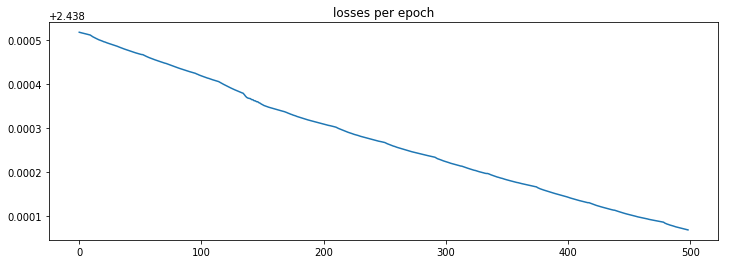

In [169]:
# plot losses
plt.figure(figsize=(12,4))
# plt.subplot(1,2,1)
# plt.plot(np.log(losses))
plt.plot((losses[-500:-1]))
plt.title('losses per epoch')

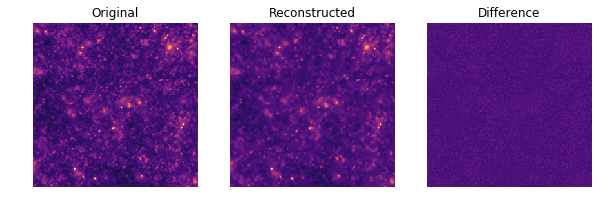

In [170]:
img = X.squeeze().cpu().data.numpy()
imgr = csc_dict(csc_weight.maps).squeeze().cpu().data.numpy()

plt.figure(figsize=(10,10))
plt.subplot(1, 3, 1)
cshow(img)
plt.title('Original')
plt.axis('off')
plt.subplot(1, 3, 2)
cshow(imgr)
plt.title('Reconstructed')
plt.axis('off')
plt.subplot(1, 3, 3)
cshow(img-imgr)
plt.title('Difference')
plt.axis('off')
plt.show()

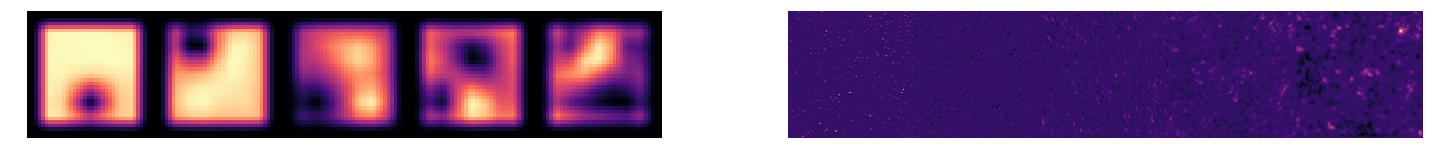

In [171]:
from skimage.transform import rescale

n_row = 1
n_col = 5
Nimages = len(csc_dict.convs)

plt.figure(figsize=(25,25))
# plot filters
plt.subplot(1, 2, 1)
p = kernel_size + 2
mosaic = np.zeros((p*n_row,p*n_col))
indx = 0
for i in range(n_row):
    for j in range(n_col):
        im = csc_dict.convs[indx].weight.data.cpu().squeeze().numpy()
        im = (im-np.min(im))
        im = im/np.max(im)
        mosaic[i*p:(i+1)*p,j*p:(j+1)*p] = np.pad(im,(1,1),mode='constant')
        indx += 1

plt.imshow(rescale(mosaic,4,mode='constant'), cmap='magma')
plt.axis('off')    

# plot each atom 
atoms = get_atoms(csc_dict.convs, csc_weight.maps)
plt.subplot(1, 2, 2)
p = img_size + 2
mosaic = np.zeros((p*n_row,p*n_col))
indx = 0
for i in range(n_row):
    for j in range(n_col):
        im = atoms[indx].data.cpu().squeeze().numpy()
        mosaic[i*p:(i+1)*p,j*p:(j+1)*p] = np.pad(im,(1,1),mode='constant',constant_values=0.)
        indx += 1

plt.imshow(rescale(mosaic,4,mode='constant'), cmap='magma')
plt.axis('off')
plt.show()        

# CD score

In [172]:
# compute cd-scores
scores = []
for comp_idx in range(n_components):
    with torch.no_grad():
        score = cd.cd(X, model, mask=None, model_type='resnet18', device='cuda', 
                transform=partial(conv_sparse_coder, atoms=atoms, comp_idx=[comp_idx]))[0].flatten()[class_num].item()
        scores.append(score)

In [173]:
activations = []
for param in csc_weight.parameters():
    activations.append(torch.abs(param.data).sum())

In [174]:
def get_residual(im: torch.Tensor, atoms: list):
    recon = 0
    for atom in atoms:
        recon += atom
    return im - recon

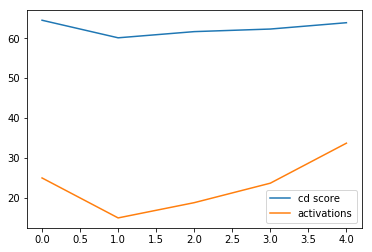

cd score for the residual: 0.12972314655780792


In [175]:
plt.plot(np.arange(n_components), 500*np.array(scores), label='cd score')
plt.plot(np.arange(n_components), activations, label='activations')
plt.legend()
plt.show()
with torch.no_grad():
    score = cd.cd(X, model, mask=None, model_type='resnet18', device='cuda', 
        transform=partial(get_residual, atoms=atoms))[0].flatten()[class_num].item()
print('cd score for the residual:', 1*score)

In [176]:
scores

[0.12911014258861542,
 0.12028267234563828,
 0.12339039146900177,
 0.12468954175710678,
 0.12786811590194702]

In [177]:
activations

[tensor(24.9210, device='cuda:0'),
 tensor(14.8765, device='cuda:0'),
 tensor(18.7101, device='cuda:0'),
 tensor(23.6060, device='cuda:0'),
 tensor(33.6586, device='cuda:0')]

# model inspection

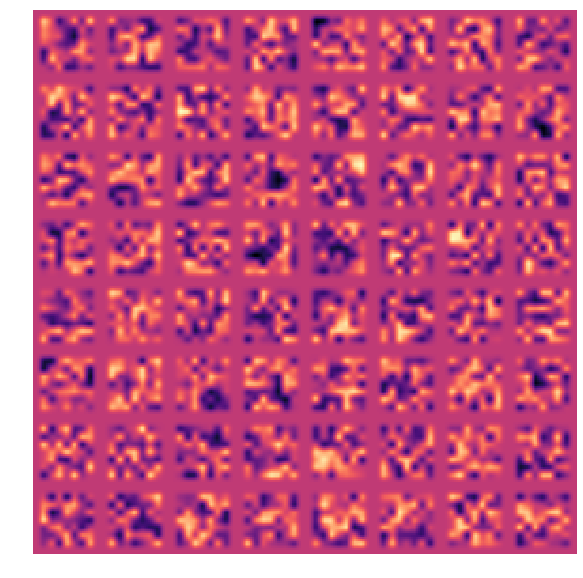

In [178]:
# plot of weights for the first conv layer
conv1_weights = []
for indx in range(64):
    conv1_weights.append(model.conv1.weight[indx].squeeze().cpu().detach().numpy())
    
plt.figure(figsize=(10,10))
n_row = 8
n_col = 8
p = 7 + 2
mosaic = np.zeros((p*n_row,p*n_col))
indx = 0
atoms = []
for i in range(n_row):
    for j in range(n_col):
        mosaic[i*p:(i+1)*p,j*p:(j+1)*p] = np.pad(conv1_weights[indx],(1,1),mode='constant')
        indx += 1

plt.imshow(rescale(mosaic,4,mode='constant'), cmap='magma')
plt.axis('off')
plt.show()        

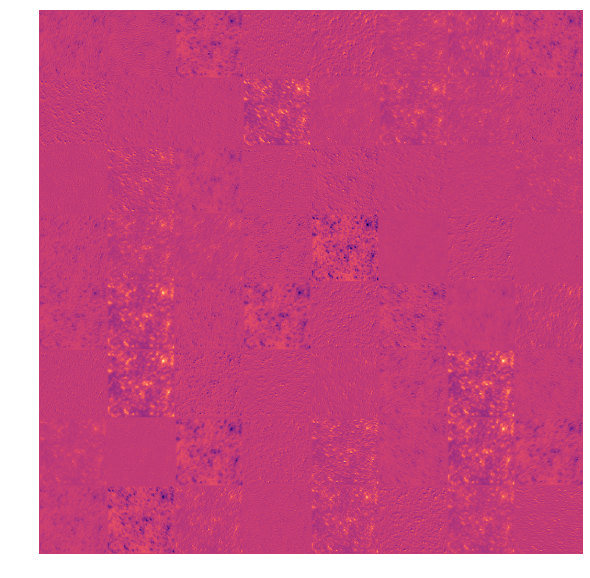

In [179]:
# plot of activation maps
feature_maps = model.conv1(X).data.cpu().detach().numpy().squeeze()

plt.figure(figsize=(10,10))
n_row = 8
n_col = 8
p = 128 + 2
mosaic = np.zeros((p*n_row,p*n_col))
indx = 0
atoms = []
for i in range(n_row):
    for j in range(n_col):
        mosaic[i*p:(i+1)*p,j*p:(j+1)*p] = np.pad(feature_maps[indx],(1,1),mode='constant')
        indx += 1

plt.imshow(rescale(mosaic,4,mode='constant'), cmap='magma')
plt.axis('off')
plt.show()        